In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [2]:
# Step 1: Define problem parameters
L = 100  # Length of domain in x and y directions
Nx = L
Ny = L  # Number of grid points in x and y
T0 = 100
alpha = 2  # Thermal diffusivity
h = 0.5206164
print(h ** 2 / (2 * alpha))
dt = 0.0125  # Time step size
nt = 1000  # Number of time steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
print(device)

0.06776035898723999
cuda


In [3]:
def apply_boundary_condition(A, b):
    pass

def create_preconditioner(A):
    sparse_indices = A._indices()
    sparse_values = A._values()

    PC = torch.zeros(A.shape[0], device=device, dtype=dtype)
    for i in range(sparse_indices.shape[1]):
        row, col = sparse_indices[:, i]
        if row == col:  # Check if it's a diagonal element
            PC[row] = sparse_values[i] 
    
    return PC


def apply_preconditioner(PC, r, tol=1e-6, max_iter=10):
    z = (1 / PC) * r
    # z = torch.linalg.solve(PC, r)
    return z

def conjugate_gradient(A, b, M, a_tol=1e-6, r_tol=1e-6, max_iter=100):
    
    x = torch.zeros_like(b, device=device, dtype=dtype)  # Initial guess (zero vector)
    r = b - A @ x            # Initial residual
    z = apply_preconditioner(M, r)  # Preconditioned residual
    p = z                    # Initial search direction

    r_norm = torch.linalg.vector_norm(r)
    
    for i in range(max_iter):
        Ap = A @ p           # Matrix-vector product A*p
        rz_scala = torch.dot(r, z)
        alpha = rz_scala / torch.dot(p, Ap)  # Step size
        
        # Update the solution
        x = x + alpha * p
        
        # Update residual
        r_new = r - alpha * Ap
        
        r_new_norm = torch.linalg.vector_norm(r_new)
        # print(r_new_norm / r_norm)
        
        if r_new_norm < a_tol or (r_new_norm / r_norm) < r_tol:
            print(f"Converged in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
            break
        
        # Apply the preconditioner iteratively
        z_new = apply_preconditioner(M, r_new)
        
        # Compute beta for the next search direction
        beta = torch.dot(r_new, z_new) / rz_scala
        
        # Update the search direction
        p = z_new + beta * p
        
        # Update residuals and preconditioned residuals for next iteration
        r = r_new
        z = z_new
        
    else:
        print(f"Did not converge in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
    return x

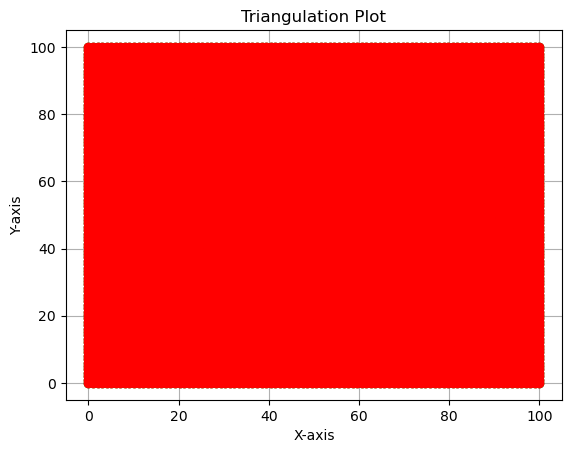

In [4]:
# Create the grid
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

Y[1:Nx-1, 1: Ny-1] += np.random.rand(Nx-2, Ny-2) * 0.5
X[1:Nx-1, 1: Ny-1] -= np.random.rand(Nx-2, Ny-2) * 0.5

# Create the original triangulation
triangulation = tri.Triangulation(X.flatten(), Y.flatten())
plt.figure()
plt.triplot(triangulation, 'go--')  # Plot the triangulation lines
plt.plot(X, Y, 'ro')  # Plot the original points
plt.title('Triangulation Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

In [5]:
# Step 3: Initial condition
u0 = torch.zeros((Nx * Ny,)).to(device=device, dtype=dtype)
u0[20 * Nx: 20 * Nx + Ny] = T0

In [6]:
def shape_function_gradients():
    # Gradients of shape functions in the reference element (master triangle)
    return torch.tensor([[-1, -1], 
                         [1, 0], 
                         [0, 1]], dtype=dtype)

def jacobian(coords):
    # Compute the Jacobian matrix for the transformation from reference to physical element
    dN_dxi = shape_function_gradients()  # Gradients in reference space
    J = coords.T @ dN_dxi  # Jacobian matrix: 2x2 for the triangle
    
    return J

def assemble_matrices(triangulation, alpha):
    npoints = len(triangulation.x)  # Total number of points in the mesh
    
    # Lists to store the indices and values of non-zero elements for K and M
    rows, cols, K_vals, M_vals = [], [], [], []
    
    for element in triangulation.triangles:
        # Get the coordinates of the three vertices of the triangle
        vertices = element[:]
        coords = torch.tensor([[x, y] for x, y in zip(triangulation.x[vertices], triangulation.y[vertices])], dtype=dtype)

        # Calculate area of the triangle using the determinant method
        area = 0.5 * torch.linalg.det(torch.tensor([
            [1, coords[0, 0], coords[0, 1]],
            [1, coords[1, 0], coords[1, 1]],
            [1, coords[2, 0], coords[2, 1]]
        ]))

        # Compute Jacobian and its inverse
        J = jacobian(coords)
        det_J = torch.linalg.det(J)   # determinant of the Jacobian matrix (related to area)
        inv_J = torch.linalg.inv(J)
        # print(det_J, 2 * area)
        
        ###############################################################################################################
        # Mass matrix for a triangular element
        Me = (det_J / 24) * torch.tensor([[2, 1, 1],
                                         [1, 2, 1],
                                         [1, 1, 2]])  # Consistent mass matrix for triangular elements

        # Compute the gradients of the shape functions in physical space (using the Jacobian inverse)
        dN_dxi = shape_function_gradients()
        dN_dxy = inv_J @ dN_dxi.T  # Now this is dN/dx and dN/dy in physical space (2x3 matrix)

        # Stiffness matrix
        Ke = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                Ke[i, j] = alpha * det_J * (dN_dxy[0, i] * dN_dxy[0, j] + dN_dxy[1, i] * dN_dxy[1, j]) 
        ################################################################################################################
        # Add local contributions to the global matrices
        for i in range(3):
            for j in range(3):
                # Store K and M values in sparse form (row, col, value)
                rows.append(vertices[i])
                cols.append(vertices[j])
                K_vals.append(Ke[i, j])
                M_vals.append(Me[i, j])
    
    # Create sparse tensors from the accumulated lists
    K = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=K_vals,
        size=(npoints, npoints)
    )
    
    M = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=M_vals,
        size=(npoints, npoints)
    )
    
    return K, M

K, M = assemble_matrices(triangulation, alpha)
K = K.to(device=device, dtype=dtype)
M = M.to(device=device, dtype=dtype)

In [7]:
U = torch.zeros((nt, Nx, Ny)).to(device=device, dtype=dtype)
U[0,:,:] = u0.reshape((Nx, Ny))

u = u0
M_dt = M * (1 / dt)
A = M_dt + K

In [8]:
dirichlet_boundary_nodes = torch.arange(20 * Nx, 20 * Nx + Ny, device=device)
boundary_values = torch.ones_like(dirichlet_boundary_nodes, device=device, dtype=dtype) * T0

sparse_indices = A._indices() # apply boundary condition
sparse_values = A._values()

mask = ~torch.isin(sparse_indices[0], dirichlet_boundary_nodes) 
new_indices = sparse_indices[:, mask]
new_values = sparse_values[mask]

identity_indices = torch.stack([dirichlet_boundary_nodes, dirichlet_boundary_nodes], dim=0).to(device=device, dtype=dtype)  # Diagonal indices
identity_values = torch.ones_like(dirichlet_boundary_nodes)  # Diagonal values are set to 1.0

final_indices = torch.cat([new_indices, identity_indices], dim=1)
final_values = torch.cat([new_values, identity_values])
A = torch.sparse_coo_tensor(final_indices, final_values, A.shape)

PC = create_preconditioner(A)

In [9]:
for n in range(1, nt):
    print(f"{n}", end=" ")
    b = torch.sparse.mm(M_dt, u.unsqueeze(1)).squeeze(1)
    
    b[dirichlet_boundary_nodes] = boundary_values # apply boundary condition
    u = conjugate_gradient(A, b, PC, a_tol=1e-5, r_tol=1e-5, max_iter=100)
    
    U[n, :, :] = u.reshape((Nx, Ny))

1 Converged in 56 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
2 Converged in 50 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
3 Converged in 43 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
4 Converged in 43 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
5 Converged in 43 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
6 Converged in 43 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
7 Converged in 44 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
8 Converged in 44 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
9 Converged in 44 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
10 Converged in 44 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
11 Converged in 44 iterations tensor(False, device='cuda:0') tensor(True, device='cuda:0')
12 Conve

KeyboardInterrupt: 

In [ ]:
def plotheatmap(tr, u_k , k):
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.tripcolor(tr, u_k.flatten(), cmap=plt.cm.jet, vmin=0, vmax=100, shading='gouraud')
    plt.colorbar()

In [ ]:
U = U.cpu()
def animate(k):
    plotheatmap(triangulation, U[k], k)

In [ ]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=nt, repeat=False)
anim.save("FEM - 2D Heat Equation - PCG - Sparse.gif")

In [ ]:
U.shape